**MULTI CLASSIFICATION WITH PYTORCH**

*DATASETS : sklearn.datasets.load_digits*

In [33]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torchmetrics as tm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [35]:
diabetes = load_digits()
x = diabetes.data
y = diabetes.target
print(y[:5])
x.shape , y.shape

[0 1 2 3 4]


((1797, 64), (1797,))

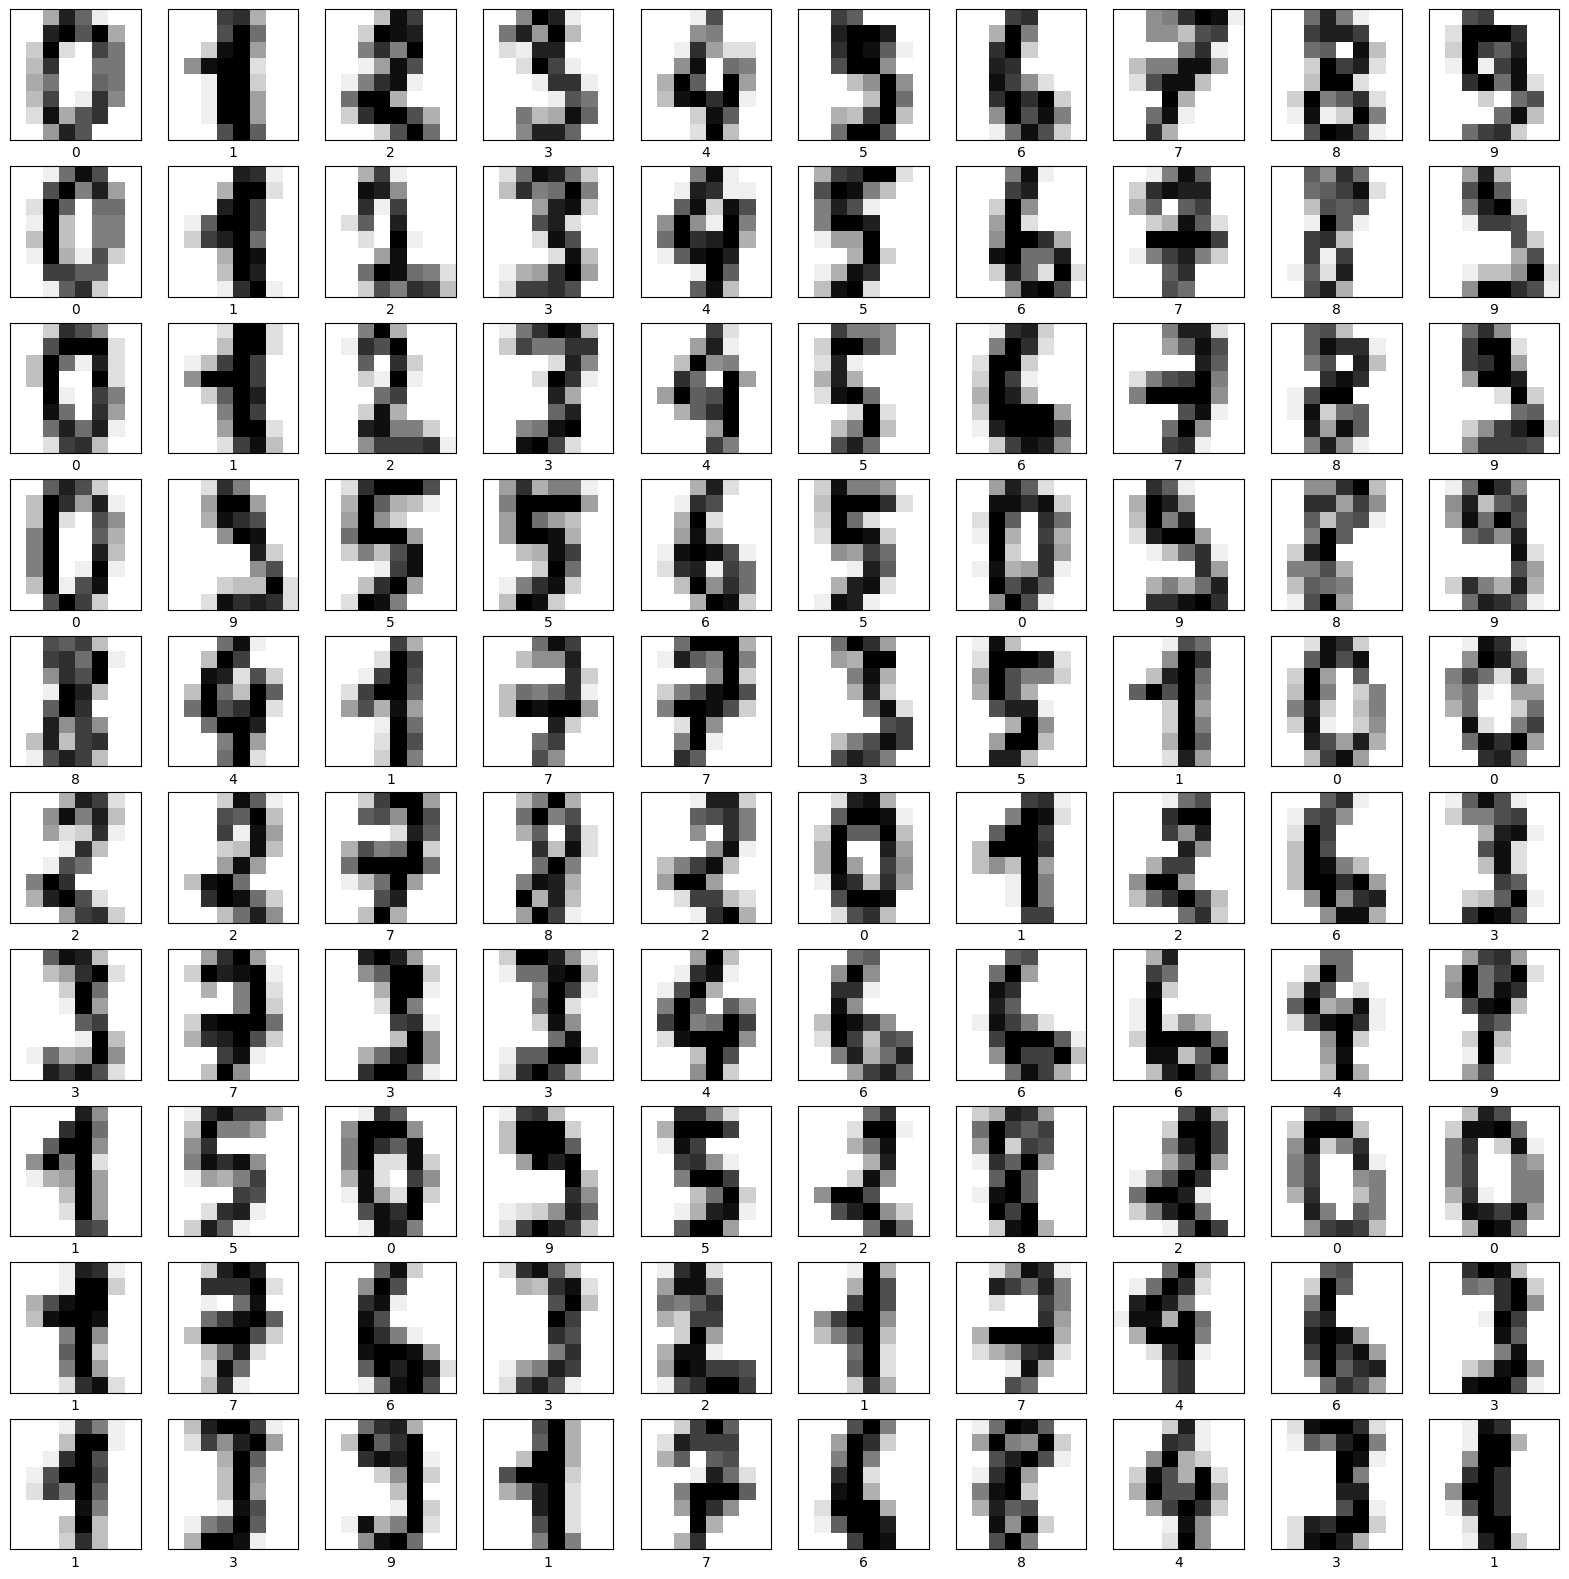

In [36]:
# Show 10x10 = 100 image and lable of train_data
numbers_to_display = 100
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(20,20))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([]) # don't show number in horizontal axis
    plt.yticks([]) # don't show number in vertical axis
    plt.imshow(x[i].reshape(8,8), cmap=plt.cm.binary) 
    plt.xlabel(y[i])
plt.show()

In [37]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

(torch.Size([1437, 64]),
 torch.Size([1437]),
 torch.Size([360, 64]),
 torch.Size([360]))

In [38]:
y.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [39]:
class MultiClassificationModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=64,out_features=128)
        self.linear2 = nn.Linear(in_features=128,out_features=128)
        self.linear3 = nn.Linear(in_features=128,out_features=10)
        self.relu = nn.ReLU()

    def forward(self,x:torch.Tensor) -> torch.Tensor :
        layer1 = self.linear1(x)
        layer2 = self.linear2(self.relu(layer1))
        layer3 = self.linear3(self.relu(layer2))
        return layer3

In [40]:
model = MultiClassificationModelV0()
print(model)

MultiClassificationModelV0(
  (linear1): Linear(in_features=64, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


In [41]:
model.eval()
with torch.inference_mode():
    y_pred_test = model(x_test)
    y_pred_label = torch.argmax(torch.softmax(y_pred_test,dim=1),dim=1)
    print(y_pred_label[:10])
    print(y_test[:10])

tensor([7, 7, 7, 7, 4, 7, 7, 7, 0, 6])
tensor([1, 0, 1, 7, 7, 9, 6, 5, 0, 2])


In [42]:
lossCross = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=model.parameters(),lr=0.01)

In [43]:
%%time
EPOCHS = 3000
epoch_list = []
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []
multi_acc = tm.Accuracy(task="multiclass", num_classes=10)

for epoch in range(EPOCHS):
    # training
    model.train()

    y_pred_train = model(x_train)
    loss_train = lossCross(y_pred_train,y_train)

    y_pred_label_train = torch.argmax(torch.softmax(y_pred_train,dim=1),dim=1)
    acc_train = multi_acc(y_pred_label_train,y_train)

    opt.zero_grad()
    loss_train.backward()
    opt.step()

    # evaluting
    model.eval()
    with torch.inference_mode():
        y_pred_test = model(x_test).type(torch.float)
        loss_test = lossCross(y_pred_test,y_test)

        y_pred_label_test = torch.argmax(torch.softmax(y_pred_test,dim=1),dim=1)
        acc_test = multi_acc(y_pred_label_test,y_test)

        if epoch % 150 == 0:
            print(f"Epoch {epoch}#")
            print(f"Loss train : {loss_train}, Accuracy train : {acc_train}%")
            print(f"Loss test : {loss_test}, Accuracy test : {acc_test}%")

            epoch_list.append(epoch)
            loss_train_list.append(loss_train.detach().numpy())
            loss_test_list.append(loss_test.detach().numpy())
            acc_train_list.append(acc_train)
            acc_test_list.append(acc_test)

Epoch 0#
Loss train : 2.419402599334717, Accuracy train : 0.13361169397830963%
Loss test : 2.3401801586151123, Accuracy test : 0.17499999701976776%
Epoch 150#
Loss train : 0.21672071516513824, Accuracy train : 0.9610299468040466%
Loss test : 0.2592785656452179, Accuracy test : 0.9388889074325562%
Epoch 300#
Loss train : 0.12272174656391144, Accuracy train : 0.9784272909164429%
Loss test : 0.17202973365783691, Accuracy test : 0.9472222328186035%
Epoch 450#
Loss train : 0.08684361726045609, Accuracy train : 0.9826026558876038%
Loss test : 0.14212675392627716, Accuracy test : 0.9527778029441833%
Epoch 600#
Loss train : 0.06646991521120071, Accuracy train : 0.9902575016021729%
Loss test : 0.12595804035663605, Accuracy test : 0.9527778029441833%
Epoch 750#
Loss train : 0.05311591550707817, Accuracy train : 0.9944328665733337%
Loss test : 0.11540583521127701, Accuracy test : 0.9583333134651184%
Epoch 900#
Loss train : 0.04375268891453743, Accuracy train : 0.9951287508010864%
Loss test : 0.10

In [44]:
model.eval()
with torch.inference_mode():
    y_pred_test = model(x_test)
    y_pred_label = torch.argmax(torch.softmax(y_pred_test,dim=1),dim=1)
    print(y_pred_label[:20])
    print(y_test[:20])

tensor([1, 0, 1, 7, 7, 9, 6, 5, 0, 2, 0, 9, 8, 8, 4, 5, 2, 0, 6, 0])
tensor([1, 0, 1, 7, 7, 9, 6, 5, 0, 2, 0, 9, 8, 9, 4, 5, 2, 0, 6, 0])


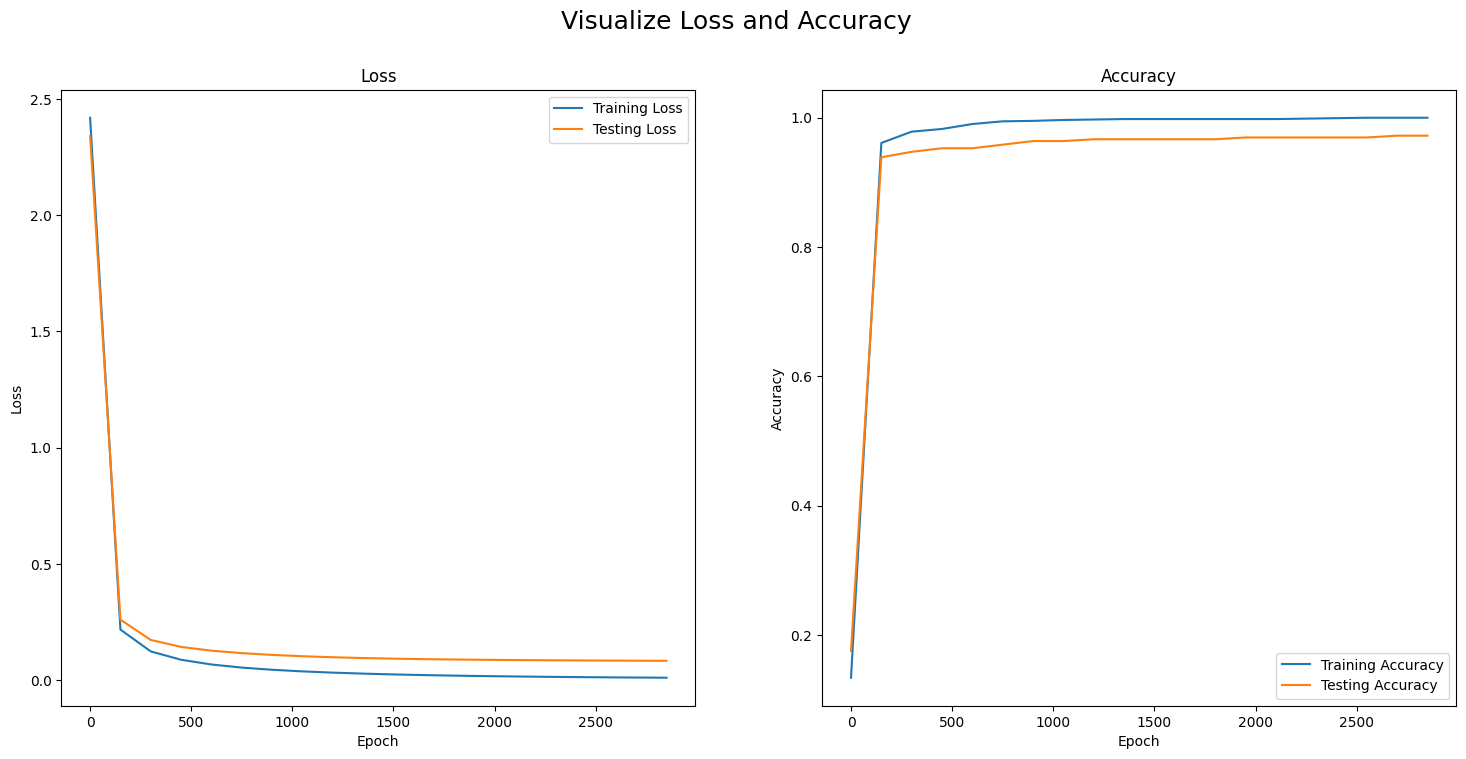

In [45]:
plt.figure(figsize=(18,8))
plt.suptitle("Visualize Loss and Accuracy", fontsize=18)

plt.subplot(1,2,1)
plt.plot(epoch_list,loss_train_list,label="Training Loss")
plt.plot(epoch_list,loss_test_list,label="Testing Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_list,acc_train_list,label="Training Accuracy")
plt.plot(epoch_list,acc_test_list,label="Testing Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [46]:
from pathlib import Path 

MODEL = Path("model")
MODEL.mkdir(parents=True,exist_ok=True)
MODEL_NAME= "digits_multi_classification_model.pth"
MODEL_PATH = MODEL / MODEL_NAME

torch.save(obj=model.state_dict(),f=MODEL_PATH)